In [12]:
import spacy
import pandas as pd
import en_core_web_md
from sklearn.feature_extraction.text import CountVectorizer
import re
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS
import itertools
import matplotlib.pyplot as plt
from IPython.display import display, Math, Latex
%matplotlib inline
from sklearn.feature_extraction.text import TfidfVectorizer 
import pandas as pd
import csv
import string
import gensim
import gensim.corpora as corpora
from pprint import pprint
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

Expected Output
(a) topic - new topics/themes for each row
(b) aspects - noun/verb
(c) adjectives
(d) sentiment (positive or negative)

### Installation

In [ ]:
spacy
https://spacy.io/usage

### Raw Data

In [3]:
df = pd.DataFrame({"Response ID":[1,2,3,4,5,6],
                  "Group":["Blue", "Yellow", "Blue", "Blue", "Red", "Blue"],
                  "Satisfied with Event":["Yes", "Yes", "Yes", "No", "No", "Yes"],
                  "Explanation":["The food was good, activites were good but the location should have been bigger for the event",
                                "Fun place with lots to do",
                                "Nice location with great scenery.",
                                "Inadequate parking and horrible food",
                                "Location was too crowded, could not participate in any of the activities",
                                "Beautiful location, though probably too small to accommodate everyone. Refreshments and activities were good"]})
df

,Response ID,Group,Satisfied with Event,Explanation
0,1,Blue,Yes,"The food was good, activites were good but the..."
1,2,Yellow,Yes,Fun place with lots to do
2,3,Blue,Yes,Nice location with great scenery.
3,4,Blue,No,Inadequate parking and horrible food
4,5,Red,No,"Location was too crowded, could not participat..."
5,6,Blue,Yes,"Beautiful location, though probably too small ..."


In [7]:
#stopwords
stopwords = nltk.corpus.stopwords.words('english')

In [17]:
#spacy model
nerModel = en_core_web_md.load()

In [8]:
# Define a function to remove punctuation 
def remove_punct(text):
    text = "".join([char for char in text if char not in string.punctuation])
    return text

def tokenize(text):
    tokens = re.split('\W+', text)
    return tokens

# Define a function to remove all stopwords
def remove_stopwords(tokenized_text): 
    stopwordList = stopwords + otherwords
    text = [word for word in tokenized_text if word not in stopwordList]
    return text

def generateNGram(text, ngram = 2):
    listOfTuples = [list(nltk.ngrams(i.split(' '), ngram)) for i in text]
    flattenListOfTuples = list(itertools.chain(*listOfTuples))
    textNGram = ['_'.join(i) for i in flattenListOfTuples]
    
    return textNGram

#Function to generate word Cloud based on frequency
def generateWC(text, n = 10):
    #get a count vectorizer
    vectorizer = CountVectorizer()
    vectorizedText = vectorizer.fit_transform(text)
    CText_Dict = {}
    for i in zip(vectorizer.get_feature_names(), np.ravel(vectorizedText.sum(axis=0))):
        CText_Dict[i[0]] = i[1]
    #get top 10 keys/words based on frequency
    topText_Dict = dict(sorted(CText_Dict.items(), key = lambda x:x[1], reverse = True)[:n])
    
    #generate word cloud
    wordcloud = WordCloud(min_font_size = 10,
                         max_words = len(CText_Dict)).generate_from_frequencies(topText_Dict)

    plt.figure(figsize = (10, 10), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()
    
    return topText_Dict

def giveSentimentScore(text):
    analyzer = SentimentIntensityAnalyzer()
    sentimentscore = analyzer.polarity_scores(text)
    score = sentimentscore['compound']
    return score

In [45]:
def givePosTag(text, posType):
    doc = nerModel(text)
    tokenList = [token for token in doc]
    posList = [token.pos_ for token in doc]
    resultList = np.where(np.array(posList) == posType, tokenList, None)
    resultList = [i for i in resultList if i]
    return resultList

In [46]:
dfOutput['Explanation'].apply(givePosTag, args = ("NOUN",))

0      [food, activites, location, event]
1                      [Fun, place, lots]
2                     [location, scenery]
3                         [parking, food]
4                  [Location, activities]
5    [location, Refreshments, activities]
Name: Explanation, dtype: object

### Text Preprocessing: 1 week

In [9]:
otherwords = ['get', 'mcdonalds', 'go', 'one', 'drive', 'like',
             'dont', 'would', 'ξi', 'im', 'ive', "1", "2", "4", "ξthe",
             "though", "iti", "said", "went", "thats", "got",
             "replied", "24", "mcd"]
dfOutput = df.copy()
dfOutput['Explanation_clean'] = dfOutput['Explanation'].map(remove_punct)
dfOutput['Explanation_tokenized'] = dfOutput['Explanation_clean'].apply(lambda x: tokenize(x.lower()))
dfOutput['Explanation_nostop_token'] = dfOutput['Explanation_tokenized'].apply(lambda x: remove_stopwords(x))
dfOutput['Explanation_nostop'] = dfOutput['Explanation_nostop_token'].map(lambda x:' '.join(x))

### Exploratory analysis: tentatively 2-3 days (pending on number of objectives to achieve here)

#### Let's see top 10 keywords for yes and no

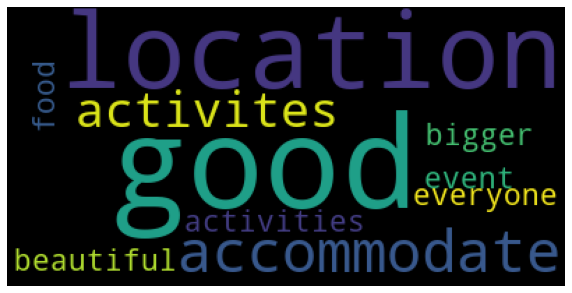

In [10]:
yesText = dfOutput.query("`Satisfied with Event` == 'Yes'")['Explanation_nostop']
a = generateWC(yesText, 10)

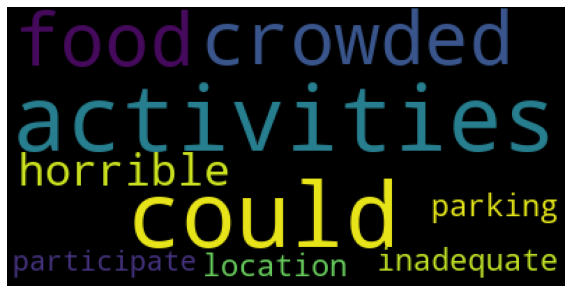

In [11]:
noText = dfOutput.query("`Satisfied with Event` == 'No'")['Explanation_nostop']
a = generateWC(noText, 10)

### Give Sentiment score: 1 week (to fine tune scores assigned to sentences, some terms may score wrongly or not exist in lexicon)

In [15]:
dfOutput['SentimentScore'] = dfOutput['Explanation_nostop'].map(giveSentimentScore)
dfOutput['SentimentType'] = dfOutput['SentimentScore'].map(lambda x: "Positive" if x>0 else "Negative")

In [16]:
dfOutput.head()

,Response ID,Group,Satisfied with Event,Explanation,Explanation_clean,Explanation_tokenized,Explanation_nostop_token,Explanation_nostop,SentimentScore,SentimentType
0,1,Blue,Yes,"The food was good, activites were good but the...",The food was good activites were good but the ...,"[the, food, was, good, activites, were, good, ...","[food, good, activites, good, location, bigger...",food good activites good location bigger event,0.7003,Positive
1,2,Yellow,Yes,Fun place with lots to do,Fun place with lots to do,"[fun, place, with, lots, to, do]","[fun, place, lots]",fun place lots,0.5106,Positive
2,3,Blue,Yes,Nice location with great scenery.,Nice location with great scenery,"[nice, location, with, great, scenery]","[nice, location, great, scenery]",nice location great scenery,0.7845,Positive
3,4,Blue,No,Inadequate parking and horrible food,Inadequate parking and horrible food,"[inadequate, parking, and, horrible, food]","[inadequate, parking, horrible, food]",inadequate parking horrible food,-0.7351,Negative
4,5,Red,No,"Location was too crowded, could not participat...",Location was too crowded could not participate...,"[location, was, too, crowded, could, not, part...","[location, crowded, could, participate, activi...",location crowded could participate activities,0.0000,Negative


### Get noun, verb, adjectives: 1-2 weeks (longer if need to improve existing model)

In [51]:
# https://spacy.io/usage/linguistic-features
dfOutput['Noun'] = dfOutput['Explanation'].apply(givePosTag, args = ("NOUN",))
dfOutput['Adjective'] = dfOutput['Explanation'].apply(givePosTag, args = ("ADJ",))
dfOutput['Verb'] = dfOutput['Explanation'].apply(givePosTag, args = ("VERB",))
dfOutput[["Response ID",'Explanation', 'Noun', 'Adjective', 'Verb']].head()

,Response ID,Explanation,Noun,Adjective,Verb
0,1,"The food was good, activites were good but the...","[food, activites, location, event]","[good, good, bigger]",[been]
1,2,Fun place with lots to do,"[Fun, place, lots]",[],[do]
2,3,Nice location with great scenery.,"[location, scenery]","[Nice, great]",[]
3,4,Inadequate parking and horrible food,"[parking, food]","[Inadequate, horrible]",[]
4,5,"Location was too crowded, could not participat...","[Location, activities]",[crowded],[participate]


### Get topic modelling: 1-2 weeks (fine tuning processing and topics)

In [54]:
# Create Dictionary
id2word = corpora.Dictionary(dfOutput['Explanation_nostop_token'])

# Create Corpus
texts = dfOutput['Explanation_nostop_token']

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# Gensim creates a unique id for each word in the document. The produced corpus shown above is a mapping of (word_id, word_frequency).

# For example, (0, 1) above implies, word id 0 occurs once in the first document. Likewise, word id 1 occurs twice and so on.

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=3, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [55]:
#let s try 3 topics 
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.106*"good" + 0.075*"location" + 0.074*"food" + 0.043*"activities" + '
  '0.043*"bigger" + 0.043*"small" + 0.043*"accommodate" + 0.043*"event" + '
  '0.043*"inadequate" + 0.043*"beautiful"'),
 (1,
  '0.134*"location" + 0.077*"could" + 0.077*"crowded" + 0.077*"scenery" + '
  '0.077*"participate" + 0.077*"great" + 0.077*"nice" + 0.077*"activities" + '
  '0.019*"fun" + 0.019*"good"'),
 (2,
  '0.040*"location" + 0.040*"fun" + 0.040*"food" + 0.040*"place" + '
  '0.040*"good" + 0.040*"lots" + 0.040*"parking" + 0.040*"activities" + '
  '0.040*"activites" + 0.040*"crowded"')]


In [56]:
lda_model.print_topics()

[(0,
  '0.106*"good" + 0.075*"location" + 0.074*"food" + 0.043*"activities" + 0.043*"bigger" + 0.043*"small" + 0.043*"accommodate" + 0.043*"event" + 0.043*"inadequate" + 0.043*"beautiful"'),
 (1,
  '0.134*"location" + 0.077*"could" + 0.077*"crowded" + 0.077*"scenery" + 0.077*"participate" + 0.077*"great" + 0.077*"nice" + 0.077*"activities" + 0.019*"fun" + 0.019*"good"'),
 (2,
  '0.040*"location" + 0.040*"fun" + 0.040*"food" + 0.040*"place" + 0.040*"good" + 0.040*"lots" + 0.040*"parking" + 0.040*"activities" + 0.040*"activites" + 0.040*"crowded"')]